# Import Libararies

In [1]:
#!pip install jupyterlab_widgets
#!pip install pandas

# PyTorch
#!pip install torch torchvision torchaudio

In [2]:
# OR TensorFlow
#!pip install tensorflow
#!pip install nltk
#!pip install transformers
#!pip install matplotlib
#!pip install torch
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install wordcloud
#!pip install textblob
#!pip install vaderSentiment
#!pip install afinn
#!pip install pywsd nltk
#!pip install spacy
#!pip install transformers
#!pip install datasets

In [3]:
import torch
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print your GPU name


True
NVIDIA GeForce RTX 4060


In [4]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

df = pd.read_csv(r"/mnt/c/Users/YapJack/Desktop/Social Computing/Combined Data.csv")

df.head()

/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


## Data Cleaning

This dataset have some missing columns, so we removed them since the count is miniscule 

In [6]:
# 1. Quick summary: count of missing values per column
print(df.isnull().sum())

# 2. Percentage of missing values per column
print((df.isnull().mean() * 100).round(2))

# 3. Total number of missing values in the entire DataFrame
print(df.isnull().sum().sum())


Unnamed: 0      0
statement     362
status          0
dtype: int64
Unnamed: 0    0.00
statement     0.68
status        0.00
dtype: float64
362


In [7]:
df = df.dropna(subset=['statement'])
print(df['statement'].isnull().sum())  # Should be 0

0


# Text Preprocessing

we follow a systematic approach to clean and prepare raw input for sentiment analysis of mental health. The key steps are:
1. Contraction Expansion
2. Sentence Tokenization
3. Noise Removal
4. Word Tokenization
5. POS Tagging
6. Case Normalization
7. Lemmatization
8. Stopword Filtering (Custom)

In [6]:
# Clean text column
df['statement'] = df['statement'].astype(str)  # Force all values to string
df = df[df['statement'].notnull()]        # Remove rows where text is NaN

In [7]:
# Download necessary NLTK resources (do it once)
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Processing Steps
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\YapJac

True

In [31]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Create stopwords set but keep negative and pronouns
stop_words = set(stopwords.words('english'))
negation_words = {"no", "nor", "not", "don", "don't", "ain", "aren", "aren't",
                  "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't",
                  "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't",
                  "isn", "isn't", "mightn", "mightn't", "mustn", "mustn't",
                  "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't",
                  "wasn", "wasn't", "weren", "weren't", "won", "won't",
                  "wouldn", "wouldn't"}

pronouns_to_keep = {'i', 'you', 'he', 'she', 'we', 'they', 'me', 'him', 'her', 'us', 'them'}

stop_words = stop_words - negation_words - pronouns_to_keep

# Expand contractions function
def expand_contractions(text):
    contractions = {
        "i'm": "i am", "i've": "i have", "i'll": "i will", "don't": "do not",
        "can't": "cannot", "won't": "will not", 
        "it isn't": "it is not", "isn't it": "is it not",
        "wasn't it": "was it not", "it wasn't": "it was not",
        "they aren't": "they are not", "aren't they": "are they not",
        "aren't we": "are we not", "we aren't": "we are not", "aren't i": "am i not",
        "weren't they": "were they not", "they weren't": "they were not",
        "you're": "you are", "he's": "he is", "she's": "she is", "it's": "it is",
        "we're": "we are", "they're": "they are"
    }

    # Create regex pattern with word boundaries, ignore case
    pattern = re.compile(r'\b(' + '|'.join(map(re.escape, contractions.keys())) + r')\b', flags=re.IGNORECASE)

    def match_case(original, replacement):
        if original.isupper():
            return replacement.upper()
        elif original[0].isupper():
            return replacement.capitalize()
        else:
            return replacement

    def replace(match):
        original = match.group(0)
        contraction = original.lower()
        expanded = contractions.get(contraction, contraction)
        return match_case(original, expanded)

    return pattern.sub(replace, text)


# Helper to convert nltk POS tags to WordNet POS tags for lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def preprocess_text(text):
    text = expand_contractions(text)

    # Sentence tokenize
    sentences = sent_tokenize(text)

    # Remove non-alphanumeric characters (excluding apostrophes)
    cleaned_sentences = [re.sub(r"[^a-zA-Z0-9\s']", " ", s) for s in sentences]

    # Tokenization
    tokens = []
    for s in cleaned_sentences:
        tokens.extend(word_tokenize(s))

    # POS tagging on original tokens (before case folding)
    # I acknowledge that spaCy provides more accurate POS tagging compared to NLTK's pos_tag.
    # However, due to resource constraints and familiarity with NTLK, pos_tag is used here.
    pos_tags = nltk.pos_tag(tokens)

    # Case folding AFTER POS tagging
    pos_tags = [(word.lower(), tag) for word, tag in pos_tags]

    # Lemmatization using POS
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ]

    # Stopword filtering
    filtered = [word for word in lemmatized if word not in stop_words]

    return ' '.join(filtered)

# Sample test
sample_text = "I'm not sure if you're going to like this! I've been feeling quite down lately — nothing seems to work, and I can't say I'm happy. However, I don't want to give up. Isn't it strange how life changes so quickly? We're trying our best, aren't we? Don't let anyone tell you otherwise."

cleaned_text = preprocess_text(sample_text)
print("\nFinal preprocessed text:\n", cleaned_text)


Final preprocessed text:
 i not sure you go like i feel quite lately nothing seem work i not say i happy however i not want give not strange life change quickly we try best we not not let anyone tell you otherwise


In [32]:
# This code is only for testing and debugging purposes 

"""
def preprocess_text(text):
    print("Original Text:\n", text, "\n")

    # 1. Expand contractions
    text = expand_contractions(text)
    print("After Contraction Expansion:\n", text, "\n")

    # 2. Sentence tokenization
    sentences = sent_tokenize(text)
    print("Sentences:\n", sentences, "\n")

    # 3. Remove non-alphanumeric characters (except apostrophes)
    cleaned_sentences = [re.sub(r"[^a-zA-Z0-9\s']", " ", s) for s in sentences]
    print("After Removing Punctuation:\n", cleaned_sentences, "\n")

    # 4. Word tokenization
    tokens = []
    for s in cleaned_sentences:
        tokens.extend(word_tokenize(s))
    print("Tokens:\n", tokens, "\n")

    # 5. POS tagging
    pos_tags = nltk.pos_tag(tokens)
    print("POS Tags:\n", pos_tags, "\n")

    # 6. Case folding after POS tagging
    pos_tags = [(word.lower(), tag) for word, tag in pos_tags]
    print("POS Tags After Case Folding:\n", pos_tags, "\n")

    # 7. Lemmatization using POS
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ]
    print("Lemmatized:\n", lemmatized, "\n")

    # 8. Remove stopwords (excluding negation and pronouns)
    filtered = [word for word in lemmatized if word not in stop_words]
    print("Filtered (No Stopwords):\n", filtered, "\n")

    # Final output
    final_output = ' '.join(filtered)
    print("Final Output:\n", final_output, "\n")
    return final_output

# Sample test
sample_text = "I'm not sure if you're going to like this! I've been feeling quite down lately — nothing seems to work, and I can't say I'm happy. However, I don't want to give up. Isn't it strange how life changes so quickly? We're trying our best, aren't we? Don't let anyone tell you otherwise."

cleaned_text = preprocess_text(sample_text)
print("\nFinal preprocessed text:\n", cleaned_text)
"""

'\ndef preprocess_text(text):\n    print("Original Text:\n", text, "\n")\n\n    # 1. Expand contractions\n    text = expand_contractions(text)\n    print("After Contraction Expansion:\n", text, "\n")\n\n    # 2. Sentence tokenization\n    sentences = sent_tokenize(text)\n    print("Sentences:\n", sentences, "\n")\n\n    # 3. Remove non-alphanumeric characters (except apostrophes)\n    cleaned_sentences = [re.sub(r"[^a-zA-Z0-9\\s\']", " ", s) for s in sentences]\n    print("After Removing Punctuation:\n", cleaned_sentences, "\n")\n\n    # 4. Word tokenization\n    tokens = []\n    for s in cleaned_sentences:\n        tokens.extend(word_tokenize(s))\n    print("Tokens:\n", tokens, "\n")\n\n    # 5. POS tagging\n    pos_tags = nltk.pos_tag(tokens)\n    print("POS Tags:\n", pos_tags, "\n")\n\n    # 6. Case folding after POS tagging\n    pos_tags = [(word.lower(), tag) for word, tag in pos_tags]\n    print("POS Tags After Case Folding:\n", pos_tags, "\n")\n\n    # 7. Lemmatization using POS

In [33]:
df['cleaned_text'] = df['statement'].apply(preprocess_text)
df[['statement', 'cleaned_text', 'status']]


,statement,cleaned_text,status
0,oh my gosh,oh gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confuse mind restless heart tune,Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...,Anxiety
3,I've shifted my focus to something else but I'...,i shift focus something else i still worried,Anxiety
4,"I'm restless and restless, it's been a month n...",i restless restless month boy you mean,Anxiety
...,...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,nobody take me seriously i 24m dealt depressio...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",selfishness i not feel good like i not belong ...,Anxiety
53040,Is there any way to sleep better? I can't slee...,way sleep good i not sleep night med n't help,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",public speak tip hi i give presentation work n...,Anxiety


# Text Processing 

**Named Entity Recognition (NER)**

In [38]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df["named_entities"] = df["statement"].apply(extract_ner)

**Word Sense Disambiguation (WSD)**

In [39]:
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('wordnet')

# Function to disambiguate multiple words
def disambiguate_words(text, words):
    tokens = word_tokenize(text)
    senses = {}
    for word in words:
        sense = lesk(tokens, word)
        senses[word] = sense.definition() if sense else None
    return senses

# Apply to each statement
ambiguous_words = [
    "stress", "depression", "anxiety", "bipolar", 
    "disorder", "suicidal", "mood", "mental", "therapy", 
    "mania", "episode", "panic", "treatment", "trigger", "support"
]

df["wsd"] = df["statement"].apply(lambda x: disambiguate_words(x, ambiguous_words))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Sentiment Lexicon / Sentiment Scoring**

In [40]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\YapJack\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [41]:
sia = SentimentIntensityAnalyzer()

# Apply VADER to each row and expand the result into separate columns
df[['neg', 'neu', 'pos', 'compound']] = df['cleaned_text'].apply(lambda x: pd.Series(sia.polarity_scores(x)))

In [42]:
df = df[['statement','cleaned_text', 'named_entities', 'wsd', 'neg', 'neu', 'pos', 'compound', 'status']]

df.to_csv("processed_data.csv", index=False)

We have processed the text. Now, we can start visualizations.

# Sentiment Anlysis

Sentiment analysis gives us a high-level emotional map of our dataset. It will help us:

1. Understand emotional tone (negative, neutral, positive) in mental health texts.

2. See how different mental health conditions correlate with sentiment.

3. Detect unusual or emotionally charged entries early (e.g., very negative suicidal posts).

In [31]:
preprocessed_df = pd.read_csv(r"/mnt/c/Users/YapJack/Desktop/Social Computing/processed_data.csv")

# Drop rows where 'cleaned_text' is NaN
preprocessed_df = preprocessed_df.dropna(subset=['cleaned_text'])

preprocessed_df.head()

,statement,cleaned_text,named_entities,wsd,neg,neu,pos,compound,status
0,oh my gosh,oh gosh,[],"{'stress': 'test the limits of', 'depression':...",0.000,1.000,0.000,0.0000,Anxiety
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confuse mind restless heart tune,[],"{'stress': 'test the limits of', 'depression':...",0.626,0.374,0.000,-0.6908,Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...,[],{'stress': '(psychology) a state of mental or ...,0.598,0.244,0.159,-0.7351,Anxiety
3,I've shifted my focus to something else but I'...,i shift focus something else i still worried,[],{'stress': 'special emphasis attached to somet...,0.306,0.694,0.000,-0.2960,Anxiety
4,"I'm restless and restless, it's been a month n...",i restless restless month boy you mean,"[('a month', 'DATE')]",{'stress': '(psychology) a state of mental or ...,0.512,0.488,0.000,-0.4939,Anxiety


Mental Health Status Counts:

Anxiety: 3841
Normal: 16300
Depression: 15403
Suicidal: 10651
Stress: 2587
Bipolar: 2777
Personality disorder: 1077


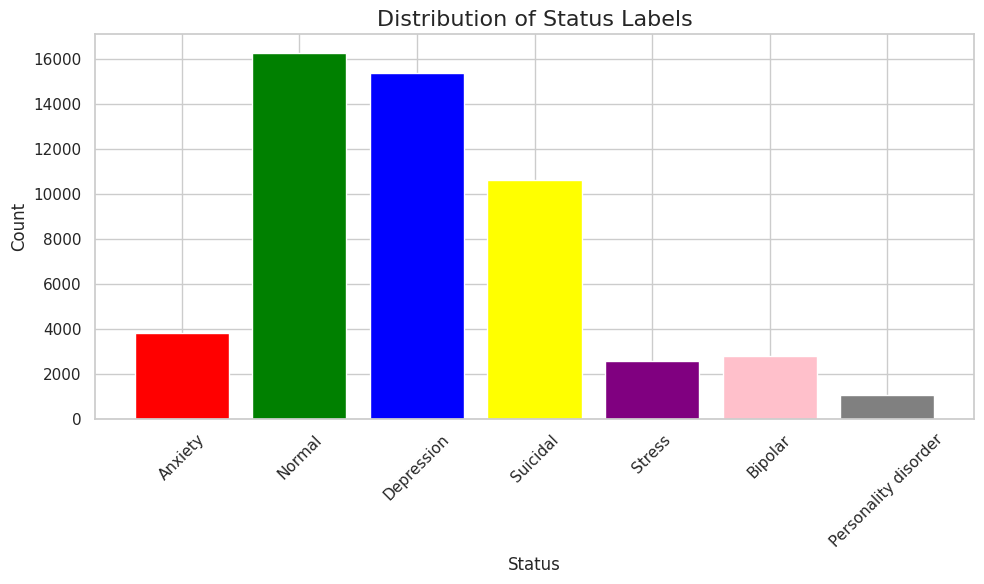

In [32]:
# Count labels
label_counts = Counter(preprocessed_df["status"])

# Custom color mapping
status_colors = {
    'Anxiety': 'red',
    'Normal': 'green',
    'Depression': 'blue',
    'Suicidal': 'yellow',
    'Stress': 'purple',
    'Bipolar': 'pink',
    'Personality disorder': 'grey',
}

# Extract labels and counts in consistent order
labels = list(label_counts.keys())
counts = [label_counts[label] for label in labels]
colors = [status_colors.get(label, 'black') for label in labels]  # default to black if missing

# Print the counts
print("Mental Health Status Counts:\n")
for label, count in zip(labels, counts):
    print(f"{label}: {count}")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=colors)
plt.title("Distribution of Status Labels", fontsize=16)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The dataset is imbalanced, with a high concentration of samples labeled as "Normal" (16,300) and "Depression" (15,403). In contrast, minority classes such as "Personality disorder" (1,077), "Stress" (2,587), "Bipolar" (2,777), and "Anxiety" (3841) are severely underrepresented.

This imbalance can pose a significant issue for our classification models, as they may become biased toward majority classes, reducing predictive performance for less frequent but clinically important categories like Suicidal, Bipolar, or Personality disorder.

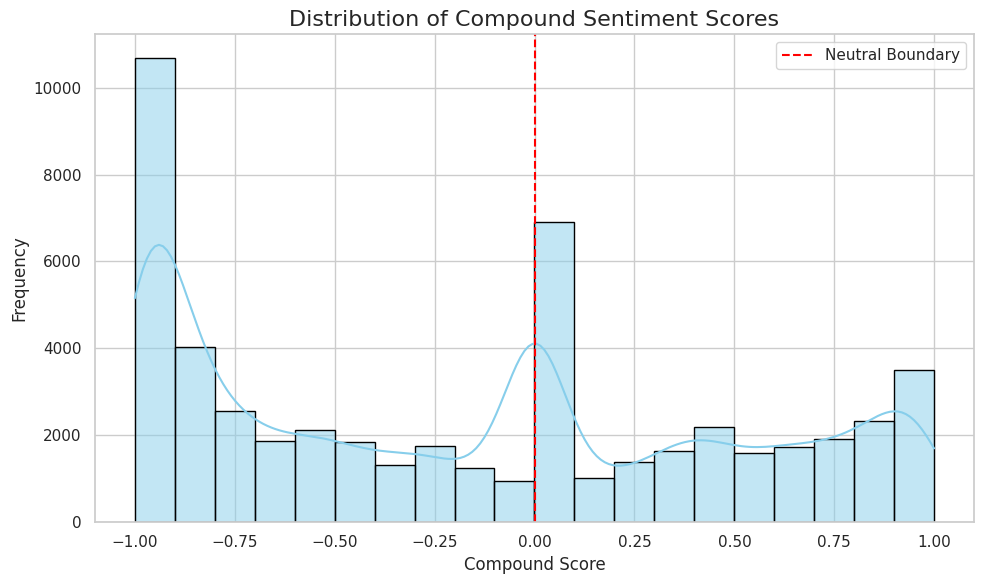

In [33]:
# Set the visual style
sns.set(style="whitegrid")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(preprocessed_df['compound'], bins=20, kde=True, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Compound Sentiment Scores', fontsize=16)
plt.xlabel('Compound Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(0, color='red', linestyle='--', label='Neutral Boundary')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

1. It can be observed that the highest number of compound score is –1.
2. The compound scores between 0 and 1 represents the “Normal” status of the dataset.

/tmp/ipykernel_579/545776717.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  compound_plot = sns.barplot(


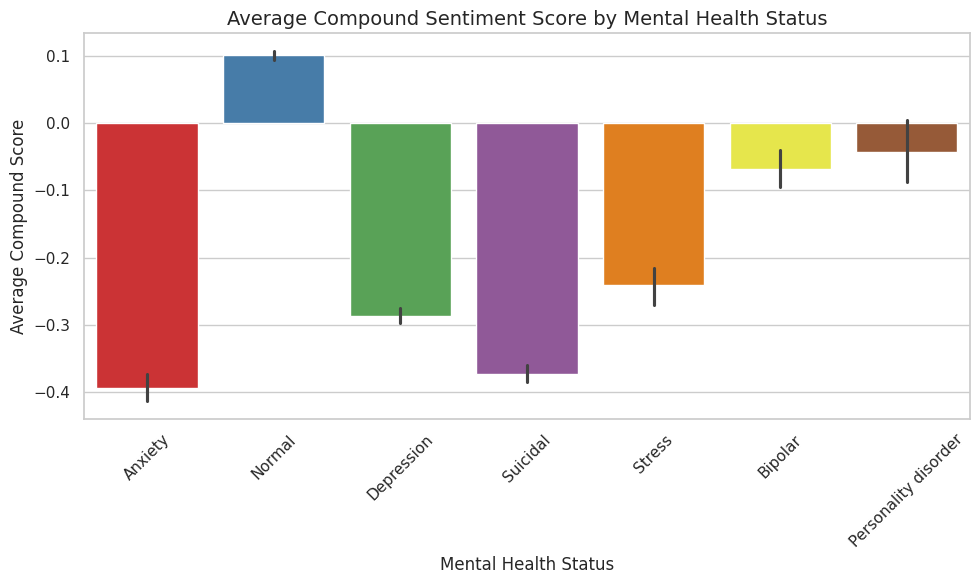

Average Compound Scores by Mental Health Status:

status
Normal                  0.101185
Personality disorder   -0.043164
Bipolar                -0.068283
Stress                 -0.241387
Depression             -0.286733
Suicidal               -0.372736
Anxiety                -0.394915
Name: compound, dtype: float64


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Subset relevant columns
data = preprocessed_df[['neg', 'neu', 'pos', 'compound', 'status']]

# Set plot size
plt.figure(figsize=(10, 6))

# Create the barplot with estimator as the actual function `np.mean`
compound_plot = sns.barplot(
    data=data,
    x='status',
    y='compound',
    palette='Set1',
    estimator=np.mean  # <-- Corrected here
)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add labels and title
plt.title("Average Compound Sentiment Score by Mental Health Status", fontsize=14)
plt.xlabel("Mental Health Status")
plt.ylabel("Average Compound Score")

# Improve layout
plt.tight_layout()
plt.show()

mean_scores = data.groupby('status')['compound'].mean().sort_values(ascending=False)
print("Average Compound Scores by Mental Health Status:\n")
print(mean_scores)

In [35]:
# Group by status and calculate mean sentiment scores
avg_sentiment = preprocessed_df.groupby('status')[['neg', 'neu', 'pos']].mean()

# Print neatly formatted results
for status in avg_sentiment.index:
    neg = avg_sentiment.loc[status, 'neg']
    neu = avg_sentiment.loc[status, 'neu']
    pos = avg_sentiment.loc[status, 'pos']
    print(f"{status:<22} Negative: {neg:.4f}   Neutral: {neu:.4f}   Positive: {pos:.4f}")

Anxiety                Negative: 0.2713   Neutral: 0.5850   Positive: 0.1437
Bipolar                Negative: 0.1847   Neutral: 0.6401   Positive: 0.1752
Depression             Negative: 0.2655   Neutral: 0.5473   Positive: 0.1871
Normal                 Negative: 0.1192   Neutral: 0.6932   Positive: 0.1865
Personality disorder   Negative: 0.1935   Neutral: 0.6181   Positive: 0.1884
Stress                 Negative: 0.2237   Neutral: 0.6173   Positive: 0.1591
Suicidal               Negative: 0.2866   Neutral: 0.5251   Positive: 0.1883


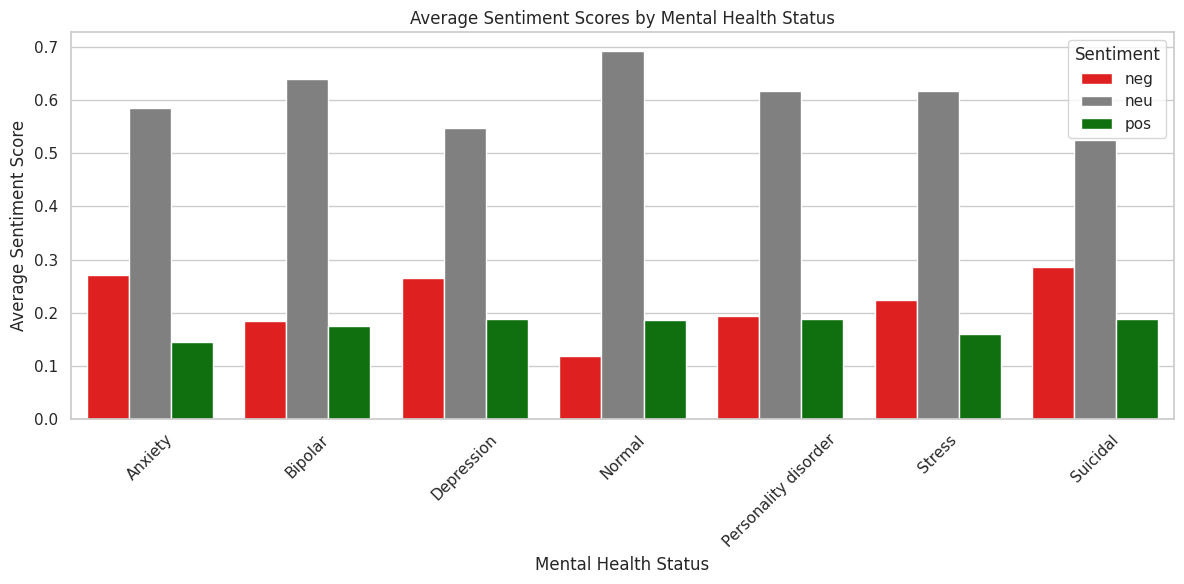

In [36]:
# Average scores per status
avg_scores = preprocessed_df.groupby('status')[['neg', 'neu', 'pos']].mean().reset_index()

# Melt the data to long format
long_df = avg_scores.melt(id_vars='status', value_vars=['neg', 'neu', 'pos'], 
                          var_name='Sentiment', value_name='Score')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x='status', y='Score', hue='Sentiment',
            palette={'neg': 'red', 'neu': 'grey', 'pos': 'green'})

plt.title('Average Sentiment Scores by Mental Health Status')
plt.xlabel('Mental Health Status')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

The chart above is used to Show a direct side-by-side comparison within each status.
On the other hand, the separated chart below provides focused, deep insight into each sentiment type (neg, neu, pos). It also highlight how each emotion behaves across mental health statuses.

/tmp/ipykernel_579/626002968.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='status', y='neg', ax=axs[0], palette=status_colors)
/tmp/ipykernel_579/626002968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='status', y='neu', ax=axs[1], palette=status_colors)
/tmp/ipykernel_579/626002968.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='status', y='pos', ax=axs[2], palette=status_colors)


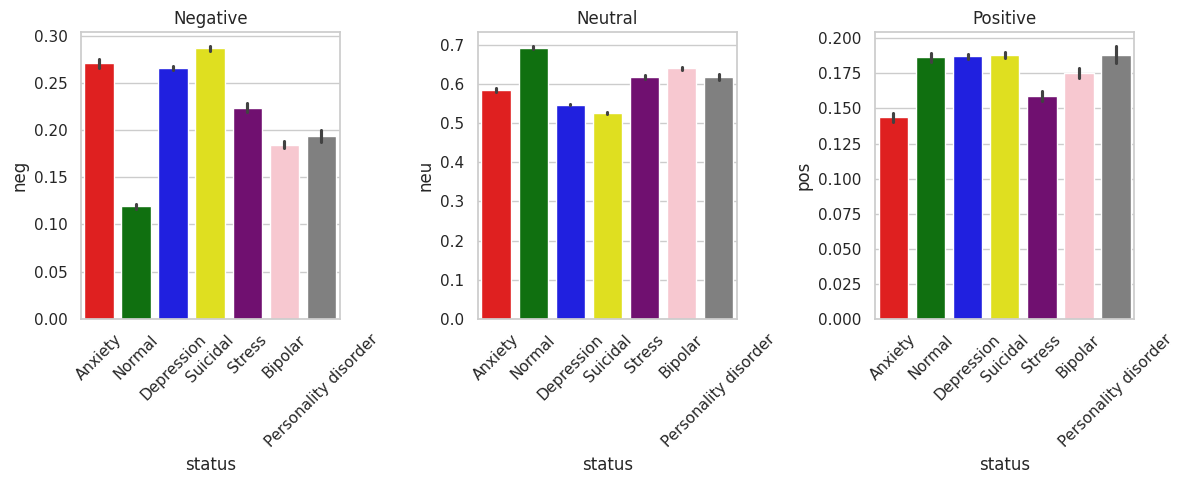

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12,5))

status_colors = {
    'Anxiety': 'red',
    'Normal': 'green',
    'Depression': 'blue',
    'Suicidal': 'yellow',
    'Stress': 'purple',
    'Bipolar': 'pink',
    'Personality disorder': 'grey',
}

sns.barplot(data=data, x='status', y='neg', ax=axs[0], palette=status_colors)
sns.barplot(data=data, x='status', y='neu', ax=axs[1], palette=status_colors)
sns.barplot(data=data, x='status', y='pos', ax=axs[2], palette=status_colors)

axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')

for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


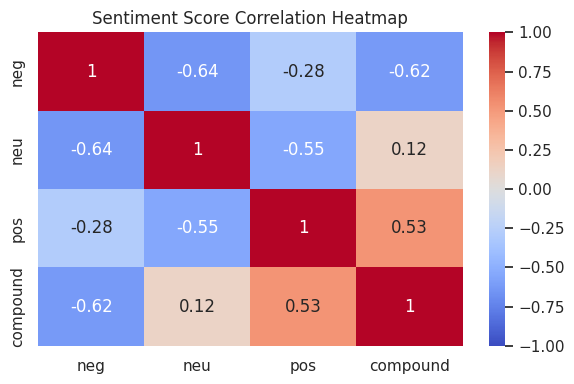

In [38]:
# Only select sentiment-related columns
sentiment_cols = ['neg', 'neu', 'pos', 'compound']
corr_matrix = preprocessed_df[sentiment_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Sentiment Score Correlation Heatmap")
plt.tight_layout()
plt.show()


- The **compound score** is highly influenced by `neg` and `pos`, not `neu`, confirming its validity as an overall polarity measure.
- The **inverse relationships** between `neu` and both `neg` and `pos` show that strong emotions (whether positive or negative) displace neutrality.
- For modeling or feature selection:
  - Consider using just the `compound` score, or a combination of `neg` and `pos`.
  - The `neu` score may be less informative unless you're specifically interested in emotionally neutral language.


Top 10 Words for Anxiety:
feel: 1.0000
go: 0.8210
anxiety: 0.8112
think: 0.7315
know: 0.7029
make: 0.4996
time: 0.4987
start: 0.4966
say: 0.4595
symptom: 0.4356


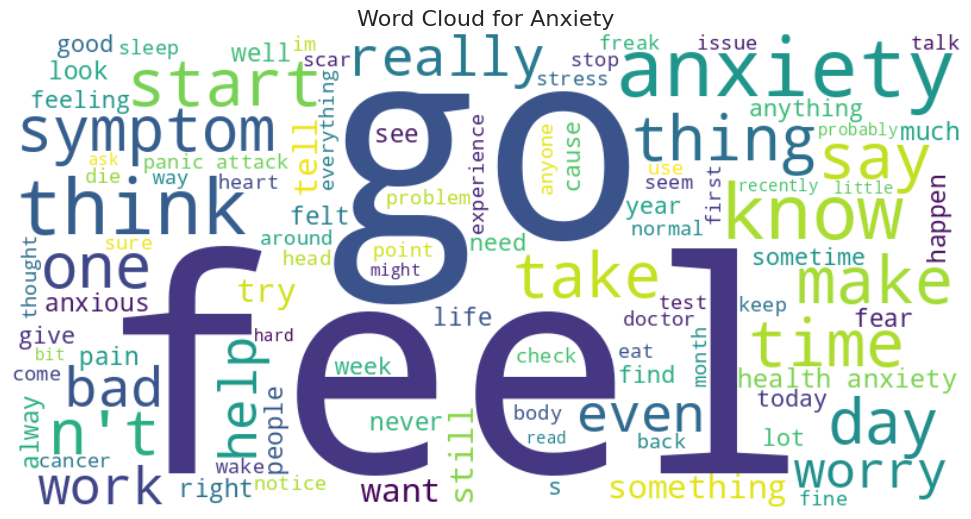


Top 10 Words for Normal:
go: 1.0000
want: 0.8037
s: 0.7028
n't: 0.6759
work: 0.6344
know: 0.6262
one: 0.6173
think: 0.6116
make: 0.6075
really: 0.5546


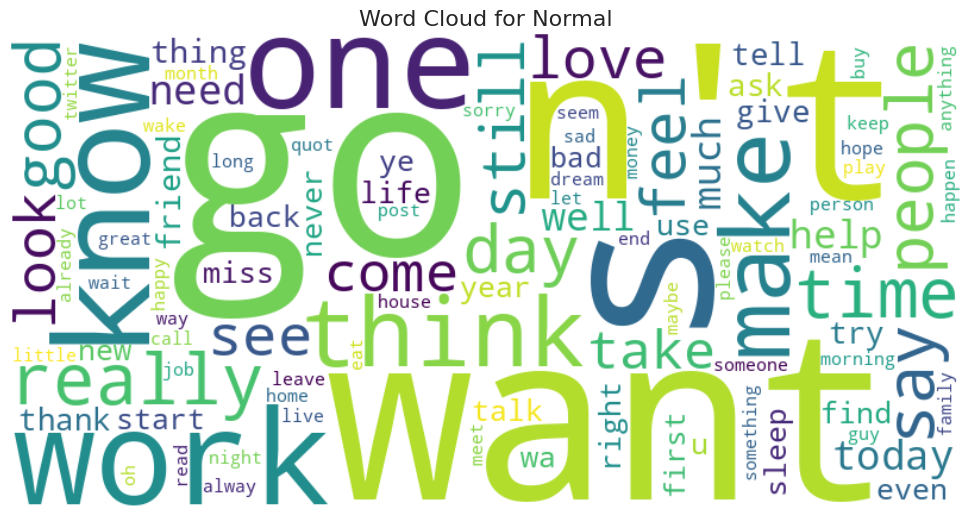


Top 10 Words for Depression:
feel: 1.0000
know: 0.7974
go: 0.6962
want: 0.6460
think: 0.6086
life: 0.6049
make: 0.5857
even: 0.5483
people: 0.4260
work: 0.4193


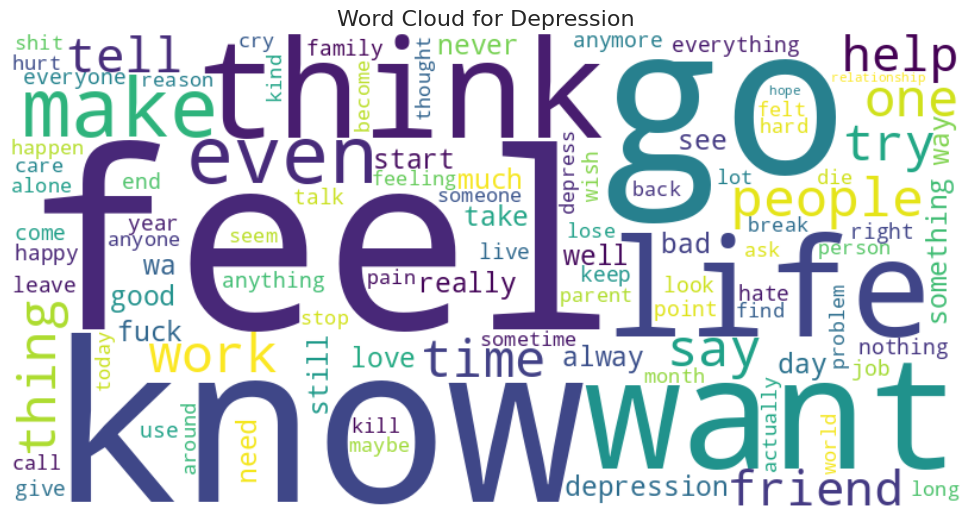


Top 10 Words for Suicidal:
know: 1.0000
feel: 0.9760
want: 0.9337
go: 0.8709
think: 0.7835
life: 0.7812
even: 0.6360
make: 0.5936
people: 0.5281
one: 0.4977


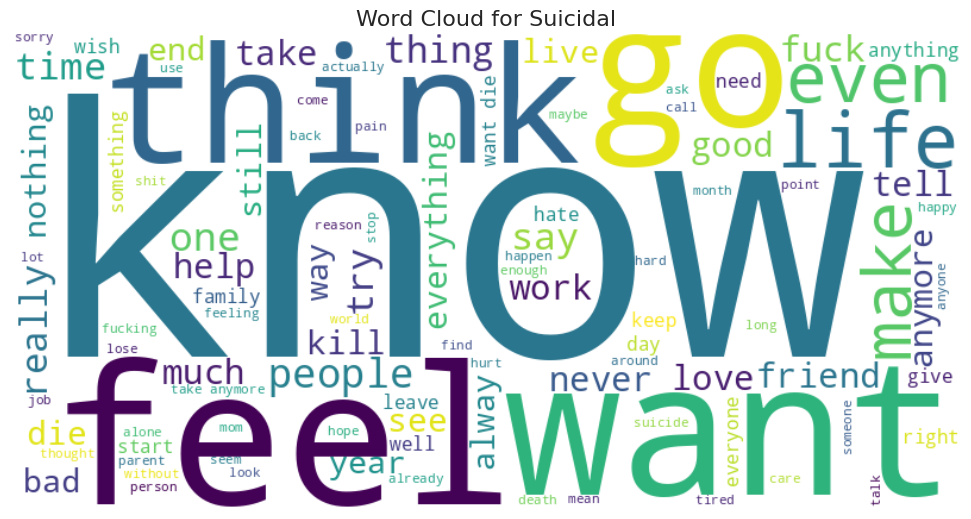


Top 10 Words for Stress:
feel: 1.0000
go: 0.8097
stress: 0.7971
work: 0.6500
know: 0.6494
time: 0.5981
make: 0.5589
want: 0.5176
think: 0.5063
thing: 0.4544


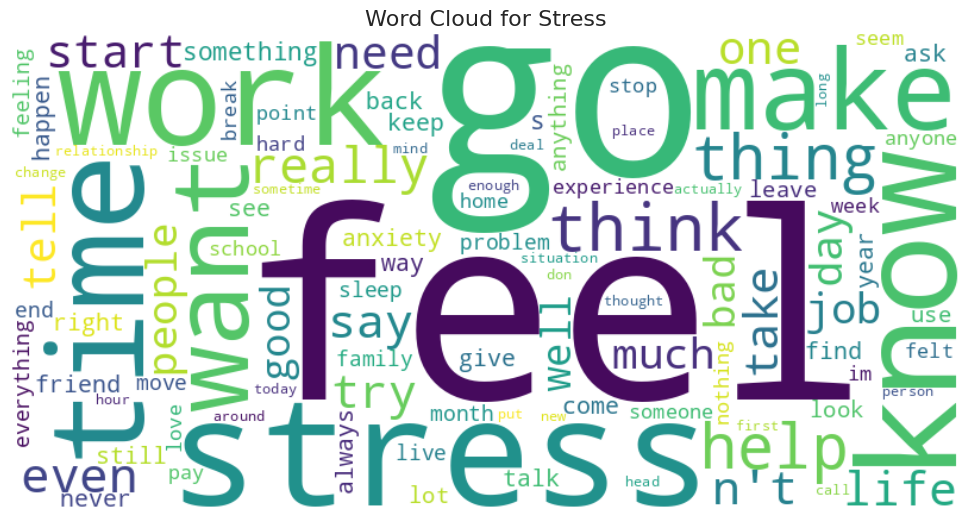


Top 10 Words for Bipolar:
feel: 1.0000
go: 0.7675
know: 0.5998
think: 0.5537
make: 0.5000
work: 0.4463
take: 0.4440
bipolar: 0.4428
want: 0.4424
time: 0.4417


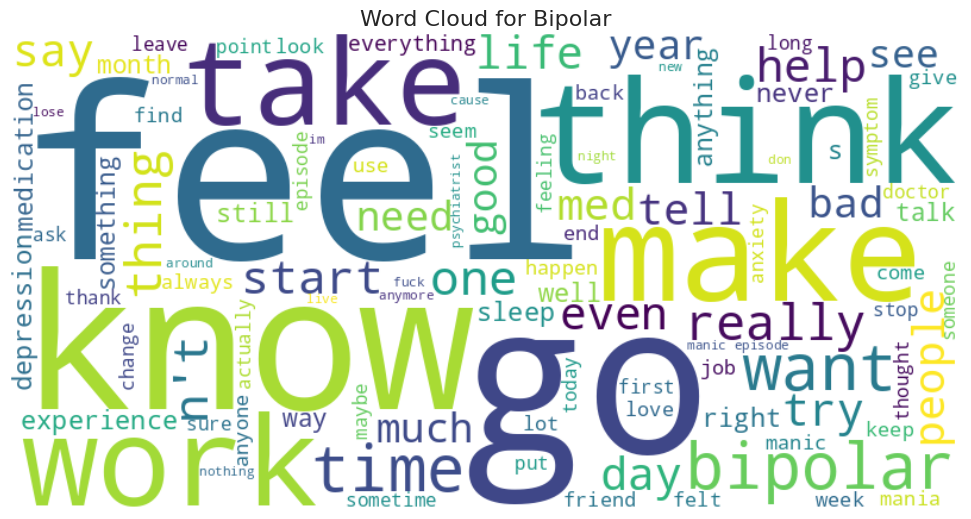


Top 10 Words for Personality disorder:
feel: 1.0000
people: 0.8228
know: 0.6496
think: 0.6173
go: 0.5945
want: 0.5591
make: 0.5197
even: 0.4803
thing: 0.4764
life: 0.4197


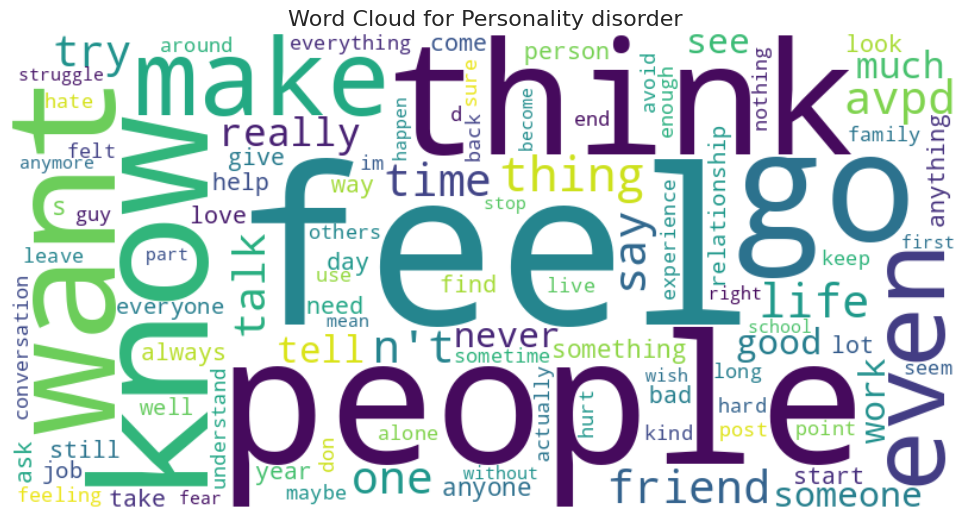

In [39]:
from wordcloud import WordCloud

labels = preprocessed_df['status'].unique()

for label in labels:
    text = ' '.join(preprocessed_df[preprocessed_df['status'] == label]['cleaned_text'].dropna())

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    
    # Get and print the top 10 most frequent words
    freqs = wordcloud.words_
    top_words = sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nTop 10 Words for {label.capitalize()}:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")
    
    # Show the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label.capitalize()}", fontsize=16)
    plt.tight_layout(pad=0)
    plt.show()


In [40]:

# Convert stringified lists to actual lists of tuples
def parse_entities(x):
    try:
        parsed = ast.literal_eval(str(x))
        return parsed if isinstance(parsed, list) else []
    except:
        return []

# Apply conversion
preprocessed_df['named_entities'] = preprocessed_df['named_entities'].apply(parse_entities)

# Print top named entity types and counts (no plots)
for label in preprocessed_df['status'].unique():
    entities = preprocessed_df[preprocessed_df['status'] == label]['named_entities'].tolist()
    
    # Flatten and extract entity types
    entity_labels = [ent[1] for sublist in entities for ent in sublist if isinstance(ent, tuple) and len(ent) == 2]
    
    top_entities = Counter(entity_labels).most_common(10)
    
    if top_entities:
        print(f"\nTop Named Entity Types for {label}:")
        for entity_type, count in top_entities:
            print(f"{entity_type}: {count}")
    else:
        print(f"\nNo named entities for {label}")


Top Named Entity Types for Anxiety:
DATE: 7181
CARDINAL: 2515
ORG: 1897
TIME: 1501
ORDINAL: 744
PERSON: 727
GPE: 581
QUANTITY: 172
PERCENT: 136
NORP: 130

Top Named Entity Types for Normal:
DATE: 2970
PERSON: 2530
ORG: 1805
CARDINAL: 1504
TIME: 1005
GPE: 804
ORDINAL: 453
NORP: 240
MONEY: 225
PRODUCT: 115

Top Named Entity Types for Depression:
DATE: 22245
CARDINAL: 7381
PERSON: 3775
TIME: 3650
ORDINAL: 2739
ORG: 2722
GPE: 1497
NORP: 645
QUANTITY: 325
MONEY: 264

Top Named Entity Types for Suicidal:
DATE: 12749
CARDINAL: 4485
TIME: 2108
PERSON: 2041
ORG: 1787
ORDINAL: 1574
GPE: 1063
NORP: 363
PERCENT: 205
QUANTITY: 205

Top Named Entity Types for Stress:
DATE: 3046
CARDINAL: 1270
ORG: 711
TIME: 700
ORDINAL: 360
PERSON: 351
GPE: 236
MONEY: 163
PERCENT: 105
NORP: 88

Top Named Entity Types for Bipolar:
DATE: 5774
CARDINAL: 2447
ORG: 1654
PERSON: 1157
TIME: 1087
ORDINAL: 676
GPE: 557
NORP: 208
MONEY: 128
PERCENT: 124

Top Named Entity Types for Personality disorder:
DATE: 1279
ORG: 739
CA

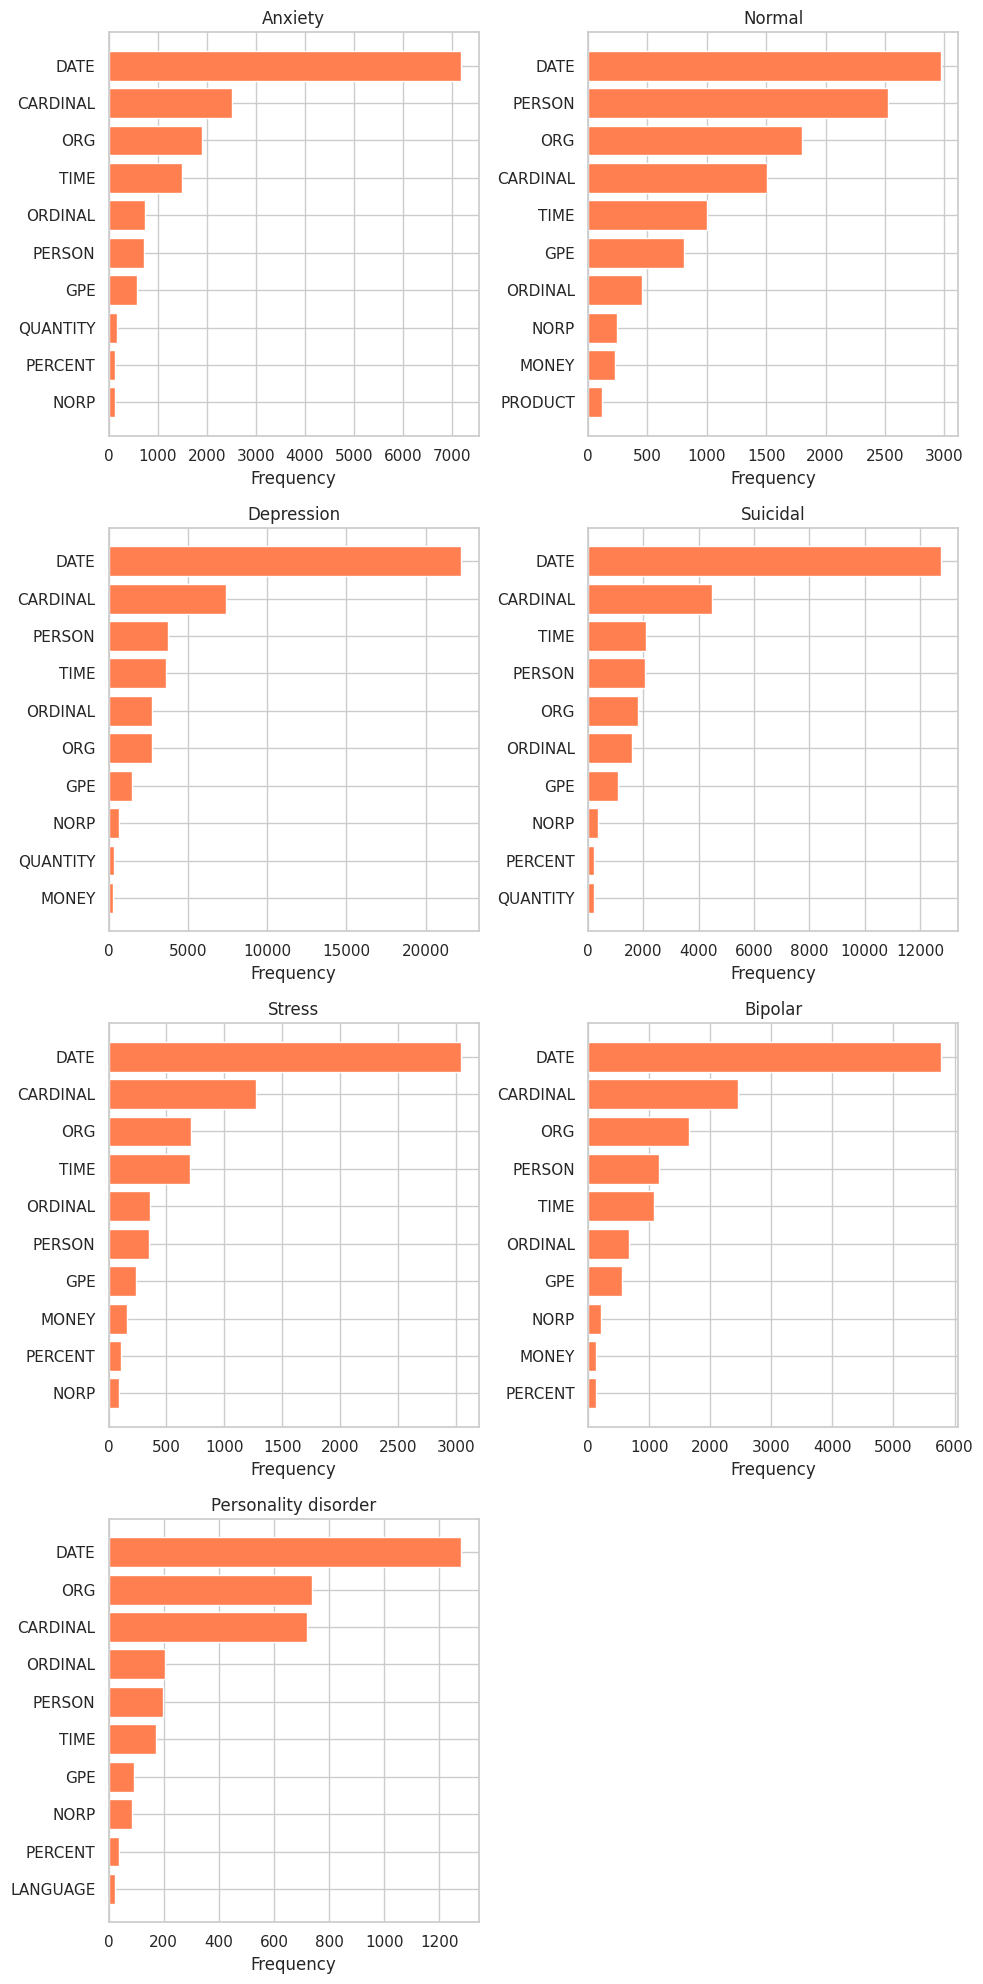

In [41]:
# Prepare figure and axes for 2 rows × 4 columns (total 8 slots, we have 7 statuses)
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten to easily index

for i, label in enumerate(preprocessed_df['status'].unique()):
    entities = preprocessed_df[preprocessed_df['status'] == label]['named_entities'].tolist()
    
    # Flatten and extract entity types
    entity_labels = [ent[1] for sublist in entities for ent in sublist if isinstance(ent, tuple) and len(ent) == 2]
    top_entities = Counter(entity_labels).most_common(10)

    if top_entities:
        ents, freqs = zip(*top_entities)
        axs[i].barh(ents, freqs, color='coral')
        axs[i].set_title(f"{label}")
        axs[i].set_xlabel("Frequency")
        axs[i].invert_yaxis()
    else:
        axs[i].text(0.5, 0.5, "No named entities", ha='center', va='center')
        axs[i].set_title(f"{label}")
        axs[i].axis('off')

# Turn off the last unused subplot (if 8 slots, 7 statuses)
if len(preprocessed_df['status'].unique()) < len(axs):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


This analysis focuses on identifying common named entity types (e.g., DATE, PERSON, TIME) in mental health-related text, categorized into the following conditions:

- **Anxiety**: Characterized by excessive worry, restlessness, or fear. 
- **Normal**: Represents emotionally neutral or mentally healthy expressions.
- **Depression**: Involves persistent sadness, hopelessness, and lack of interest in activities.
- **Suicidal**: Indicates intent, thoughts, or expressions related to self-harm or suicide.
- **Stress**: Refers to emotional tension or pressure from challenging situations.
- **Bipolar**: A disorder marked by extreme mood swings, from mania to depression.
- **Personality Disorder**: Involves rigid and unhealthy patterns of thinking or behavior.

1. Anxiety: Anxiety-related texts often reference **time** (e.g., "yesterday", "a month") and **quantities** (e.g., "3 days", "5 hours"). This suggests individuals with anxiety frequently express concerns tied to scheduling, deadlines, or repetitive rumination over specific timeframes and events.
  
2. Normal: Neutral texts reference **people**, **organizations**, and **locations** more often, possibly reflecting everyday conversations. There's a balanced distribution, implying that normal text includes a wider social and contextual variety.

3. Depression: The dominance of `DATE` and `TIME` reflects a preoccupation with **duration** or the **passage of time** — common in depression narratives ("it's been weeks..."). The high `CARDINAL` and `ORDINAL` usage suggests **enumeration** of symptoms or life events.

4. Suicidal: These texts are rich in temporal references (e.g., "tomorrow", "last night"), which may relate to **planning**, **reflection**, or **crisis timelines**. Mentions of **people** may imply isolation or relational conflicts, often linked to suicidal ideation.

5. Stress: Organizational and time mentions suggest that **workplace or institutional stressors** are common themes. `MONEY` and `PERCENT` also appear, indicating financial-related stress.

6. Bipolar: High `DATE` and `CARDINAL` usage could indicate **tracking of mood episodes or medication schedules**. `PERSON` and `ORG` may reflect references to **healthcare providers**, family, or institutions.

7. Personality Disorder: Focus on **organizations** may reflect **institutional support or diagnosis experiences**. The presence of `LANGUAGE` suggests discussion of communication patterns or identity.

**Sentence Sentiment Classification**

In [42]:
#!pip install scikit-learn

Feature Engineering

In [43]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
preprocessed_df['label'] = label_encoder.fit_transform(preprocessed_df['status'])
preprocessed_df

,statement,cleaned_text,named_entities,wsd,neg,neu,pos,compound,status,label
0,oh my gosh,oh gosh,[],"{'stress': 'test the limits of', 'depression':...",0.000,1.000,0.000,0.0000,Anxiety,0
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confuse mind restless heart tune,[],"{'stress': 'test the limits of', 'depression':...",0.626,0.374,0.000,-0.6908,Anxiety,0
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...,[],{'stress': '(psychology) a state of mental or ...,0.598,0.244,0.159,-0.7351,Anxiety,0
3,I've shifted my focus to something else but I'...,i shift focus something else i still worried,[],{'stress': 'special emphasis attached to somet...,0.306,0.694,0.000,-0.2960,Anxiety,0
4,"I'm restless and restless, it's been a month n...",i restless restless month boy you mean,"[(a month, DATE)]",{'stress': '(psychology) a state of mental or ...,0.512,0.488,0.000,-0.4939,Anxiety,0
...,...,...,...,...,...,...,...,...,...,...
52676,Nobody takes me seriously I’ve (24M) dealt wit...,nobody take me seriously i 24m dealt depressio...,"[(years, DATE), (about a year, DATE), (more th...",{'stress': 'the relative prominence of a sylla...,0.151,0.643,0.206,0.8696,Anxiety,0
52677,"selfishness ""I don't feel very good, it's lik...",selfishness i not feel good like i not belong ...,"[(creepy, NORP), (A few years ago, DATE)]",{'stress': 'the relative prominence of a sylla...,0.365,0.454,0.181,-0.9830,Anxiety,0
52678,Is there any way to sleep better? I can't slee...,way sleep good i not sleep night med n't help,[],{'stress': 'the relative prominence of a sylla...,0.186,0.576,0.239,0.1635,Anxiety,0
52679,"Public speaking tips? Hi, all. I have to give ...",public speak tip hi i give presentation work n...,"[(next week, DATE), (45 minutes, TIME)]",{'stress': '(physics) force that produces stra...,0.231,0.665,0.104,-0.6249,Anxiety,0


In [44]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
X = preprocessed_df[['cleaned_text']]
y= preprocessed_df['label']

X_resampled , y_resampled = ros.fit_resample(X , y)

preprocessed_df = pd.concat([X_resampled, y_resampled], axis = 1)
preprocessed_df

,cleaned_text,label
0,oh gosh,0
1,trouble sleep confuse mind restless heart tune,0
2,wrong back dear forward doubt stay restless re...,0
3,i shift focus something else i still worried,0
4,i restless restless month boy you mean,0
...,...,...
114095,value life i happy happy moment drown crap lif...,6
114096,i struggle thoughs four yea i able distract th...,6
114097,everything wrong life pain disappointment ever...,6
114098,anyone else feel way like i tired fight shit e...,6


In [45]:
print(preprocessed_df['label'].value_counts())

label
0    16300
3    16300
2    16300
6    16300
5    16300
1    16300
4    16300
Name: count, dtype: int64


In [46]:
# Step 3: Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(preprocessed_df['cleaned_text'])
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5370233 stored elements and shape (114100, 5000)>

In [49]:
# Step 4: Model Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming 'sentiment' is the label column
X_train, X_test, y_train, y_test = train_test_split(X, preprocessed_df['label'], test_size=0.2, random_state=42)

## Logistic Regression

In [50]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))

Accuracy: 0.8385188431200701
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3367
           1       0.93      0.92      0.92      3220
           2       0.70      0.56      0.62      3328
           3       0.86      0.91      0.88      3292
           4       0.91      0.99      0.95      3250
           5       0.83      0.87      0.85      3177
           6       0.72      0.74      0.73      3186

    accuracy                           0.84     22820
   macro avg       0.83      0.84      0.84     22820
weighted avg       0.83      0.84      0.83     22820



/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))

Accuracy: 0.920464504820333
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3367
           1       0.98      1.00      0.99      3220
           2       0.82      0.70      0.76      3328
           3       0.89      0.93      0.91      3292
           4       1.00      1.00      1.00      3250
           5       0.98      0.99      0.99      3177
           6       0.79      0.83      0.81      3186

    accuracy                           0.92     22820
   macro avg       0.92      0.92      0.92     22820
weighted avg       0.92      0.92      0.92     22820



## KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))

Accuracy: 0.6656879929886065
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      3367
           1       0.98      0.90      0.94      3220
           2       0.72      0.05      0.09      3328
           3       0.30      0.95      0.46      3292
           4       0.97      1.00      0.99      3250
           5       0.99      0.92      0.95      3177
           6       0.79      0.10      0.18      3186

    accuracy                           0.67     22820
   macro avg       0.82      0.67      0.64     22820
weighted avg       0.81      0.67      0.63     22820



## Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))

Accuracy: 0.8808939526730938
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3367
           1       0.95      1.00      0.97      3220
           2       0.75      0.58      0.65      3328
           3       0.89      0.84      0.86      3292
           4       0.97      1.00      0.98      3250
           5       0.92      1.00      0.96      3177
           6       0.73      0.77      0.75      3186

    accuracy                           0.88     22820
   macro avg       0.88      0.88      0.88     22820
weighted avg       0.88      0.88      0.88     22820



# Classification Model Contruction

In [9]:
preprocessed_df = pd.read_csv(r"/mnt/c/Users/YapJack/Desktop/Social Computing/processed_data.csv")

preprocessed_df.head()

,statement,cleaned_text,named_entities,wsd,neg,neu,pos,compound,status
0,oh my gosh,oh gosh,[],"{'stress': 'test the limits of', 'depression':...",0.000,1.000,0.000,0.0000,Anxiety
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confuse mind restless heart tune,[],"{'stress': 'test the limits of', 'depression':...",0.626,0.374,0.000,-0.6908,Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...,[],{'stress': '(psychology) a state of mental or ...,0.598,0.244,0.159,-0.7351,Anxiety
3,I've shifted my focus to something else but I'...,i shift focus something else i still worried,[],{'stress': 'special emphasis attached to somet...,0.306,0.694,0.000,-0.2960,Anxiety
4,"I'm restless and restless, it's been a month n...",i restless restless month boy you mean,"[('a month', 'DATE')]",{'stress': '(psychology) a state of mental or ...,0.512,0.488,0.000,-0.4939,Anxiety


In [10]:
preprocessed_df = preprocessed_df.dropna()
print(preprocessed_df.isnull().sum())

statement         0
cleaned_text      0
named_entities    0
wsd               0
neg               0
neu               0
pos               0
compound          0
status            0
dtype: int64


In [14]:
preprocessed_df

,cleaned_text,status
0,oh gosh,Anxiety
1,trouble sleep confuse mind restless heart tune,Anxiety
2,wrong back dear forward doubt stay restless re...,Anxiety
3,i shift focus something else i still worried,Anxiety
4,i restless restless month boy you mean,Anxiety
...,...,...
114095,value life i happy happy moment drown crap lif...,Suicidal
114096,i struggle thoughs four yea i able distract th...,Suicidal
114097,everything wrong life pain disappointment ever...,Suicidal
114098,anyone else feel way like i tired fight shit e...,Suicidal


In [17]:
text_column = 'cleaned_text'
labels = 'label'
model_name = 'bert-base-uncased'
test_size = 0.2
num_labels = 7

In [18]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(preprocessed_df[text_column] , preprocessed_df['label'] , test_size= 0.2 , random_state= 42)

## Tokenize

In [18]:
from transformers import AutoTokenizer

In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True , max_length = 200)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length = 200)

first_encoding = {key: val[0] for key, val in train_encodings.items()}
print(first_encoding)

/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fce7d34b910>>
Traceback (most recent call last):
  File "/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


{'input_ids': [101, 1005, 1055, 2307, 2057, 2025, 11429, 2217, 1057, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
from datasets import Dataset

#convert to dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],'attention_mask': train_encodings['attention_mask'],'labels': y_train.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],'attention_mask': test_encodings['attention_mask'],'labels': y_test.tolist()})

## Initialize Model

In [24]:
from transformers import AutoModelForSequenceClassification
from torch.nn import CrossEntropyLoss
from collections import Counter
import torch

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train Model

In [22]:
#!pip install tf-keras
#!pip install evaluate
#!pip install transformers[torch]
#!pip install --upgrade "accelerate>=0.26.0"

In [23]:
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

In [24]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [29]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [30]:
trainer.train()

Step,Training Loss
10,0.437900
20,0.423200
30,0.309500
40,0.363900
50,0.505600
60,0.365100
70,0.386600
80,0.313700
90,0.438700
100,0.357600


TrainOutput(global_step=28525, training_loss=0.19132032163633814, metrics={'train_runtime': 8938.6243, 'train_samples_per_second': 51.059, 'train_steps_per_second': 3.191, 'total_flos': 4.6909873668e+16, 'train_loss': 0.19132032163633814, 'epoch': 5.0})

In [ ]:
trainer.save_model('MHC_model')

In [31]:
from sklearn.metrics import classification_report

In [35]:
preds , labels , _ = trainer.predict(test_dataset)
print(preds)

[[ 8.133793   -2.10512    -0.5586424  ... -3.642539   -2.0360029
  -1.5056393 ]
 [-1.7193221  -2.4328816  -1.2201487  ... -1.8441509  -1.4330232
  -1.8203038 ]
 [-1.0763552  -2.5645745   8.480906   ... -3.178076   -2.826419
  -0.34087497]
 ...
 [-2.4680285  -3.7576756   7.9936047  ... -2.6274273  -3.449778
   2.0814345 ]
 [-0.14032993 -2.309578    7.7804804  ... -4.77785    -3.4817488
   1.5024024 ]
 [-2.3142536  -2.4154718  -0.9329137  ... -2.4494696  10.035449
  -2.3855433 ]]


In [36]:
#convert predictions to class labels
predicted_labels = np.argmax(preds, axis=1)

print(classification_report(y_test , predicted_labels , target_names = label_encoder.classes_))

                      precision    recall  f1-score   support

             Anxiety       0.97      0.99      0.98      3367
             Bipolar       0.98      1.00      0.99      3220
          Depression       0.83      0.73      0.78      3328
              Normal       0.95      0.93      0.94      3292
Personality disorder       0.99      1.00      1.00      3250
              Stress       0.95      1.00      0.97      3177
            Suicidal       0.79      0.83      0.81      3186

            accuracy                           0.93     22820
           macro avg       0.92      0.93      0.92     22820
        weighted avg       0.92      0.93      0.92     22820



## Full Pipeline

In [19]:
# === Essential Imports ===
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch

def run_text_classification_pipeline_nosave(
    model_name: str,
    num_labels: int,
    X_train: X_train, y_train: y_train,
    X_test: X_test, y_test: y_test,
    label_encoder: label_encoder,
    learning_rate: float = 5e-5,
    per_device_train_batch_size: int = 16,
    per_device_eval_batch_size=16,
    num_epochs: int = 5,
    weight_decay: float = 0.01
):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Tokenize data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=200)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=200)

    # Convert to Hugging Face Dataset
    train_dataset = Dataset.from_dict({
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'labels': y_train.tolist()
    })
    test_dataset = Dataset.from_dict({
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'labels': y_test.tolist()
    })

    # Define compute_metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc}

    # Disable saving/logging
    training_args = TrainingArguments(
        output_dir="./tmp",  # required but will not be used
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        logging_steps=1000,
        save_strategy="no",
        evaluation_strategy="no",
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Evaluate
    preds_train = trainer.predict(train_dataset).predictions
    preds_test = trainer.predict(test_dataset).predictions

    preds_train_labels = np.argmax(preds_train, axis=1)
    preds_test_labels = np.argmax(preds_test, axis=1)

    print("\nTrain Classification Report:")
    print(classification_report(y_train, preds_train_labels, target_names=label_encoder.classes_))

    print("\nTest Classification Report:")
    print(classification_report(y_test, preds_test_labels, target_names=label_encoder.classes_))

/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [20]:
trainer = run_text_classification_pipeline_nosave(
    model_name="emilyalsentzer/Bio_ClinicalBERT",
    num_labels=7,
    X_train= X_train, y_train= y_train,
    X_test= X_test, y_test= y_test,
    label_encoder= label_encoder
)

/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitl

Step,Training Loss
1000,0.965700
2000,0.579500
3000,0.495500
4000,0.427900
5000,0.387200
6000,0.332500
7000,0.274100
8000,0.255600
9000,0.247600
10000,0.256400



Train Classification Report:
                      precision    recall  f1-score   support

             Anxiety       1.00      1.00      1.00     12933
             Bipolar       1.00      1.00      1.00     13080
          Depression       0.99      0.97      0.98     12972
              Normal       1.00      1.00      1.00     13008
Personality disorder       1.00      1.00      1.00     13050
              Stress       1.00      1.00      1.00     13123
            Suicidal       0.97      0.99      0.98     13114

            accuracy                           0.99     91280
           macro avg       0.99      0.99      0.99     91280
        weighted avg       0.99      0.99      0.99     91280


Test Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.98      0.99      0.99      3367
             Bipolar       0.99      1.00      0.99      3220
          Depression       0.84      0.75      0.79      3328
       

In [21]:
trainer = run_text_classification_pipeline_nosave(
    model_name = "roberta-base",
    num_labels=7,
    X_train= X_train, y_train= y_train,
    X_test= X_test, y_test= y_test,
    label_encoder= label_encoder
)

/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
1000,1.013500
2000,0.687000
3000,0.600900
4000,0.532100
5000,0.478700
6000,0.421000
7000,0.370900
8000,0.349600
9000,0.330000
10000,0.329500



Train Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.99      1.00      1.00     12933
             Bipolar       1.00      1.00      1.00     13080
          Depression       0.97      0.91      0.94     12972
              Normal       0.99      0.99      0.99     13008
Personality disorder       1.00      1.00      1.00     13050
              Stress       0.99      1.00      1.00     13123
            Suicidal       0.93      0.97      0.95     13114

            accuracy                           0.98     91280
           macro avg       0.98      0.98      0.98     91280
        weighted avg       0.98      0.98      0.98     91280


Test Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.98      0.99      0.99      3367
             Bipolar       0.98      1.00      0.99      3220
          Depression       0.85      0.74      0.79      3328
       

In [22]:
trainer = run_text_classification_pipeline_nosave(
    model_name = "google/mobilebert-uncased",  # or any other model
    num_labels=7,
    X_train= X_train, y_train= y_train,
    X_test= X_test, y_test= y_test,
    label_encoder= label_encoder
)

/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/yapjack/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untru

Step,Training Loss
1000,14979.559000
2000,0.622800
3000,0.505800
4000,0.529100
5000,0.438800
6000,0.328800
7000,0.290600
8000,0.312400
9000,0.251600
10000,0.254500



Train Classification Report:
                      precision    recall  f1-score   support

             Anxiety       1.00      1.00      1.00     12933
             Bipolar       1.00      1.00      1.00     13080
          Depression       0.98      0.95      0.96     12972
              Normal       1.00      1.00      1.00     13008
Personality disorder       1.00      1.00      1.00     13050
              Stress       1.00      1.00      1.00     13123
            Suicidal       0.95      0.98      0.97     13114

            accuracy                           0.99     91280
           macro avg       0.99      0.99      0.99     91280
        weighted avg       0.99      0.99      0.99     91280


Test Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.98      1.00      0.99      3367
             Bipolar       0.98      1.00      0.99      3220
          Depression       0.84      0.73      0.78      3328
       

## Bar Chart of Model Comparison

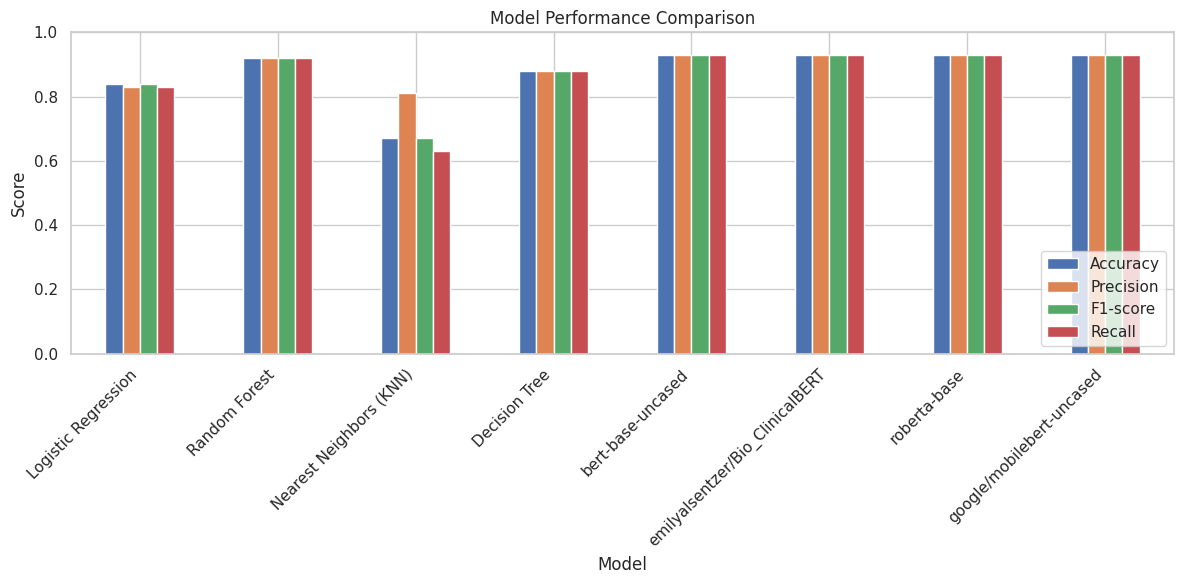

In [54]:
# Create the data
data = {
    'Model': [
        'Logistic Regression', 'Random Forest', 'Nearest Neighbors (KNN)',
        'Decision Tree', 'bert-base-uncased', 'emilyalsentzer/Bio_ClinicalBERT',
        'roberta-base', 'google/mobilebert-uncased'
    ],
    'Accuracy': [0.84, 0.92, 0.67, 0.88, 0.93, 0.93, 0.93, 0.93],
    'Precision': [0.83, 0.92, 0.81, 0.88, 0.93, 0.93, 0.93, 0.93],
    'F1-score': [0.84, 0.92, 0.67, 0.88, 0.93, 0.93, 0.93, 0.93],
    'Recall': [0.83, 0.92, 0.63, 0.88, 0.93, 0.93, 0.93, 0.93]
}


# Convert to DataFrame
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# Plotting
df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(True)
plt.show()
